# Retail Data Analytics and Data Wrangling

## Imports

In [0]:
from pyspark.sql.functions import col, when, regexp_replace, date_format, sum, min, max, ntile, datediff, lit, concat, avg,
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import FloatType

## Data Preparation

In [0]:
# File location and type
f1_location = "/FileStore/tables/retail-1.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
retail_df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(f1_location)

retail_df = retail_df.withColumn('total_amount', col('quantity') * col('unit_price'))

## Total Invoice Amount Distribution

In [0]:
filtered_df = retail_df.filter(
    (col('invoice_no').rlike('^\d+$')) & (col('total_amount') > 0)
)

invoice_total_df = filtered_df.groupBy('invoice_no').sum('total_amount')

Minimum: 0.19
Mean: 523.0445268489885
Median: 303.38
Mode: 15.0
Maximum: 168469.6


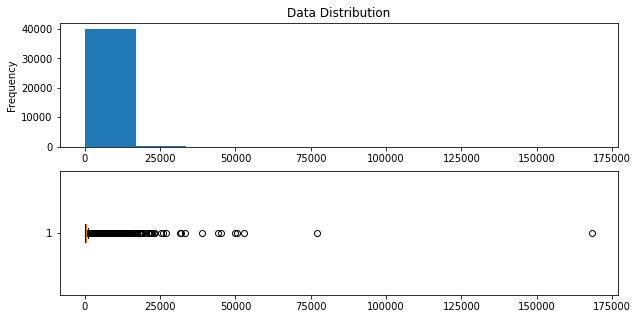

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

def graph(df):
    min_value = df.agg(F.min('sum(total_amount)')).collect()[0][0]
    max_value = df.agg(F.max('sum(total_amount)')).collect()[0][0]
    mean_value = df.agg(F.avg('sum(total_amount)')).collect()[0][0]
    median_value = df.approxQuantile('sum(total_amount)', [0.5], 0.01)[0]
    mode_value = df.groupBy('sum(total_amount)').count().orderBy(F.desc('count')).first()[0]

    print('Minimum:', min_value)
    print('Mean:', mean_value)
    print('Median:', median_value)
    print('Mode:', mode_value)
    print('Maximum:', max_value)
    
    values = df.select('sum(total_amount)').rdd.flatMap(lambda x: x).collect()

    # Plotting
    fig, ax = plt.subplots(2, 1)
    fig.set_size_inches(10,5)
    
    ax[0].set_title('Data Distribution')
    ax[0].hist(values)
    ax[0].set_ylabel('Frequency')
    
    ax[1].boxplot(values, vert=False)
    plt.show()

# Assuming 'invoice_total_df' is your Spark DataFrame
graph(invoice_total_df)

Minimum: 0.19
Mean: 266.71517490054157
Median: 247.89999999999998
Mode: 15.0
Maximum: 691.4000000000002


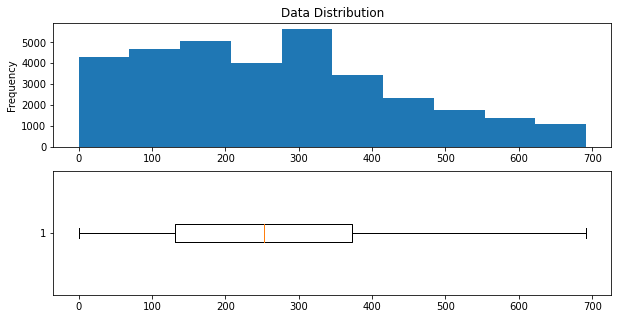

In [0]:
quant_val = invoice_total_df.approxQuantile('sum(total_amount)', [0.85], 0.01)[0]

invoice_total_df_agg = invoice_total_df.groupBy('invoice_no').agg(F.sum('sum(total_amount)').alias('sum(total_amount)'))
invoice_total_outliers_df = invoice_total_df_agg.filter(col('sum(total_amount)') <= quant_val)

graph(invoice_total_outliers_df)

## Monthly Placed and Canceled Order

In [0]:
retail_df = retail_df.withColumn("invoice_date", col("invoice_date").cast("date"))
retail_df = retail_df.withColumn("invoice_date", date_format("invoice_date", "yyyyMM"))

In [0]:
filtered_cancels = retail_df.filter(retail_df.total_amount < 0) \
    .dropDuplicates(['invoice_no'])

cancels = filtered_cancels.groupBy("invoice_date") \
    .agg(F.count("invoice_no").alias("cancels"))

orders = retail_df.dropDuplicates(['invoice_no']) \
    .groupBy("invoice_date") \
    .agg(F.count("invoice_no").alias("placements"))

monthly_orders = orders.join(cancels, on="invoice_date", how="left") \
    .withColumn("Placement", orders["placements"] - 2 * cancels["cancels"]) \
    .select("invoice_date", "Placement", "cancels") \
    .orderBy("invoice_date")

monthly_orders = monthly_orders.withColumnRenamed("cancels", "Cancellation")

# cancels.show(5)
# orders.show(5)
monthly_orders.show(5)

+------------+---------+------------+
|invoice_date|Placement|Cancellation|
+------------+---------+------------+
|      200912|     1528|         401|
|      201001|     1033|         300|
|      201002|     1491|         239|
|      201003|     1553|         407|
|      201004|     1282|         305|
+------------+---------+------------+
only showing top 5 rows



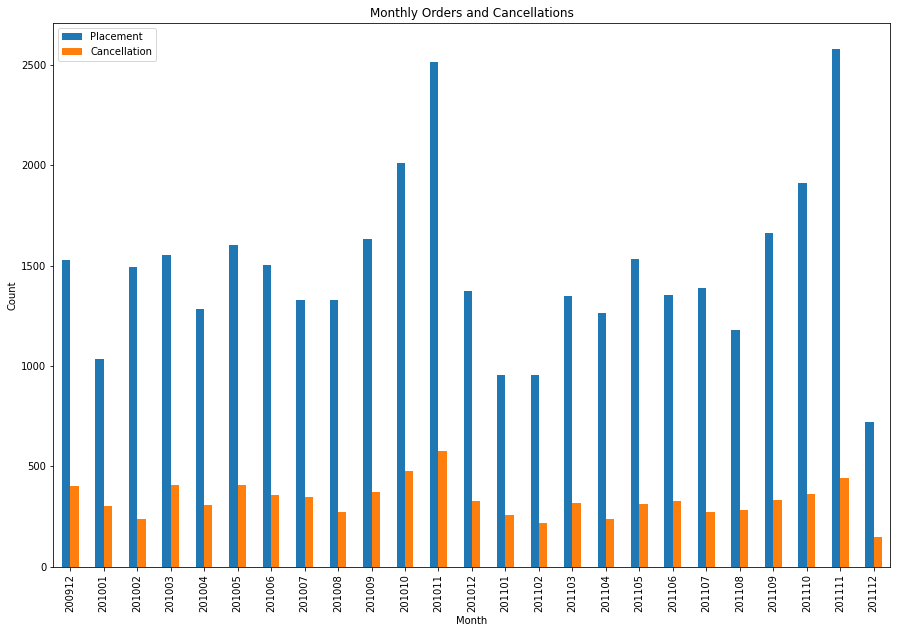

In [0]:
monthly_orders = monthly_orders.dropDuplicates()
monthly_orders_pd = monthly_orders.toPandas()

monthly_orders_pd.plot.bar(x='invoice_date', y=['Placement', 'Cancellation'], figsize=(15, 10))

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Orders and Cancellations')

plt.show()

## Montly Sales

Out[62]: Text(0.5, 0, 'Month')

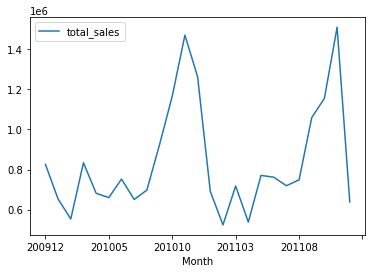

In [0]:
monthly_sales = retail_df.filter(col("invoice_no").rlike("^[0-9]+$")) \
    .groupBy("invoice_date") \
    .agg(sum("total_amount").alias("total_sales")) \
    .orderBy("invoice_date")

monthly_sales_pd = monthly_sales.toPandas()
monthly_sales_pd.plot.line(x='invoice_date', y='total_sales')
plt.xlabel('Month')


## Monthly Sales Growth

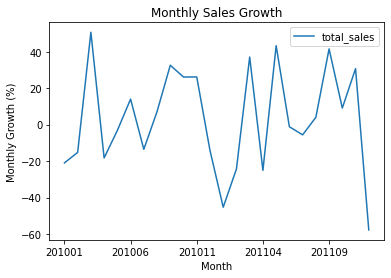

In [0]:
monthly_sales_pd.set_index("invoice_date", inplace=True)
monthly_growth = monthly_sales_pd.pct_change() * 100
monthly_growth.dropna(inplace=True)

monthly_growth.plot.line()
plt.xlabel('Month')
plt.ylabel('Monthly Growth (%)')
plt.title('Monthly Sales Growth')
plt.show()

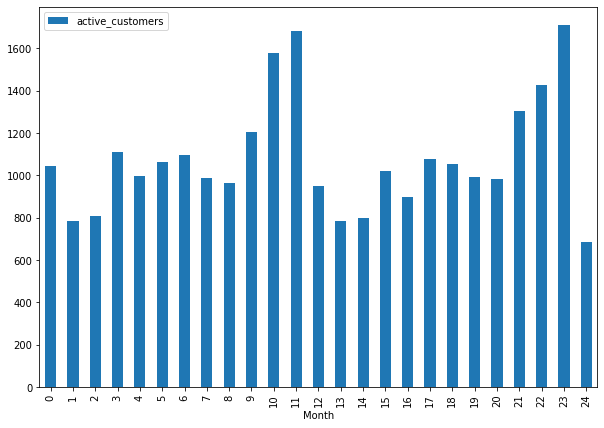

In [0]:
monthly_active = retail_df.groupBy("invoice_date") \
    .agg(F.countDistinct("customer_id").alias("active_customers")) \
    .orderBy("invoice_date")

# monthly_active.show(1)

monthly_active_pd = monthly_active.toPandas()
monthly_active_pd.plot.bar(figsize=(10, 7))
plt.xlabel('Month')
plt.show()

## New and Existing Users

In [0]:
window_spec = Window.partitionBy("customer_id") ## partitioning by cid
temp_df = retail_df.withColumn("first_purchase_month", min("invoice_date").over(window_spec))

new_users = temp_df.filter(temp_df.first_purchase_month == temp_df.invoice_date)
new_users_count = new_users.groupBy("invoice_date") \
    .agg(F.countDistinct("customer_id").alias("new_users_count")) \
    .orderBy("invoice_date")

previous_users = temp_df.filter(temp_df.first_purchase_month < temp_df.invoice_date)

previous_users_count = previous_users.groupBy("invoice_date") \
    .agg(F.countDistinct("customer_id").alias("previous_users_count")) \
    .orderBy("invoice_date")

Out[130]: <matplotlib.legend.Legend at 0x75eb1a290be0>

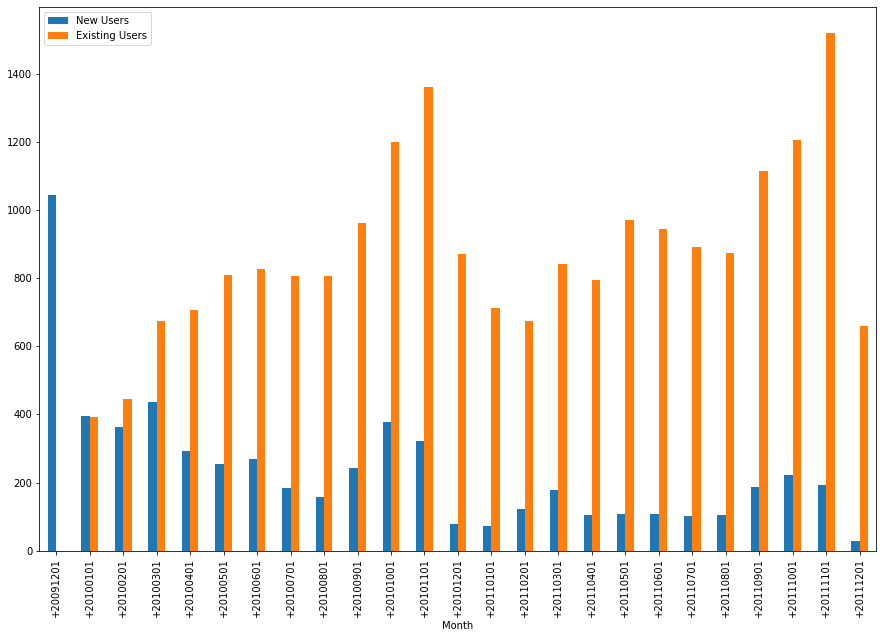

In [0]:
new_users_count_pd = new_users_count.toPandas().set_index("invoice_date")
previous_users_count_pd = previous_users_count.toPandas().set_index("invoice_date")

merged_data = pd.concat([new_users_count_pd, previous_users_count_pd], axis=1).fillna(0)

merged_data.columns = ["New Users", "Previous Users"]
merged_data.plot.bar(figsize=(15, 10))

plt.xlabel('Month')
plt.legend(labels=['New Users', 'Existing Users'])

## Finding RFM

In [0]:
# retail_df = retail_df.withColumn("invoice_date", F.to_date(retail_df["invoice_date"]))
# reference_date = retail_df.select(max("invoice_date")).collect()[0][0]
# reference_date = F.to_date(lit(reference_date))

# rfm = retail_df.filter(retail_df.customer_id.isNotNull()) \
#     .groupBy("customer_id") \
#     .agg(
#         datediff(lit(reference_date), max("invoice_date")).alias("Recency"),
#         (F.count("invoice_no")).alias("Frequency"),
#         F.round(sum("total_amount"), 2).alias("Monetary")
#     ) \
#     .orderBy("customer_id")

# rfm.show(5)


+-----------+-------+---------+--------+
|customer_id|Recency|Frequency|Monetary|
+-----------+-------+---------+--------+
|      12346|    325|       48|  -64.68|
|      12347|      2|      253| 5633.32|
|      12348|     75|       51|  2019.4|
|      12349|     18|      180| 4404.54|
|      12350|    310|       17|   334.4|
+-----------+-------+---------+--------+
only showing top 5 rows



## RFM Segmentation

In [0]:
# recency_window = Window.orderBy(F.col("Recency").asc())
# frequency_window = Window.orderBy(F.col("Frequency").desc())
# monetary_window = Window.orderBy(F.col("Monetary").desc())

# rfm = rfm.withColumn("recency_score", F.ntile(5).over(recency_window))
# rfm = rfm.withColumn("frequency_score", F.ntile(5).over(frequency_window))
# rfm = rfm.withColumn("monetary_score", F.ntile(5).over(monetary_window))

# rfm = rfm.withColumn("rfm_combined", 
#                      F.concat(F.col("recency_score").cast("string"), 
#                               F.col("frequency_score").cast("string")))

# rfm = rfm.withColumn("segment", F.when(F.col("rfm_combined").rlike("^[1-2][1-2]$"), "Hibernating")
#     .when(F.col("rfm_combined").rlike("^[1-2][3-4]$"), "At Risk")
#     .when(F.col("rfm_combined") == "15", "Can't Lose")
#     .when(F.col("rfm_combined").rlike("^3[1-2]$"), "About to Sleep")
#     .when(F.col("rfm_combined") == "33", "Need Attention")
#     .when(F.col("rfm_combined").rlike("^[3-4][4-5]$"), "Loyal Customers")
#     .when(F.col("rfm_combined") == "41", "Promising")
#     .when(F.col("rfm_combined") == "51", "New Customers")
#     .when(F.col("rfm_combined").rlike("^[4-5][2-3]$"), "Potential Loyalists")
#     .when(F.col("rfm_combined").rlike("^5[4-5]$"), "Champions")
#     .otherwise("Other"))

# result = rfm.groupBy("segment").agg(
#     F.count("*").alias("count"),
#     F.avg("Recency").alias("mean_recency"),
#     F.avg("Frequency").alias("mean_frequency"),
#     F.avg("Monetary").alias("mean_monetary")
# )

# result = result.orderBy("segment")

# result.show()

+-------------------+-----+------------------+------------------+------------------+
|            segment|count|      mean_recency|    mean_frequency|     mean_monetary|
+-------------------+-----+------------------+------------------+------------------+
|     About to Sleep|  486|105.73251028806584| 207.6090534979424|3267.4146090534996|
|            At Risk|  694| 24.29971181556196|42.935158501440924|1106.2076368876071|
|         Can't Lose|   65| 9.923076923076923| 7.953846153846154|  649.347076923077|
|          Champions|  855| 564.0643274853801|14.601169590643275| 214.0726666666664|
|        Hibernating| 1503| 19.01929474384564| 367.1357285429142| 7790.779095143059|
|    Loyal Customers| 1038|229.98265895953756|17.717726396917147| 484.6414065510598|
|     Need Attention|  276|107.73913043478261| 55.77536231884058|1381.0380797101454|
|      New Customers|   28|470.42857142857144|252.71428571428572| 2860.832857142857|
|              Other|  116|35.793103448275865|  8.96551724137931|